# Import Related Package

In [1]:
# Config GPU Resource
# https://stackoverflow.com/questions/55788883/limiting-gpu-memory-usage-by-keras-tf-2019
# https://www.bookstack.cn/read/TensorFlow2.0/spilt.6.3b87bc87b85cbe5d.md

GPU_NUMBER = "0"

import os
os.environ['CUDA_VISIBLE_DEVICES']=f"{GPU_NUMBER}"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(devices=gpus, device_type='GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# packages
from tensorflow import keras
import tensorflow.keras.layers 
import tensorflow.keras.backend
from tensorflow.keras import utils as np_utils
from tensorflow.python.client import device_lib
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import struct
import pathlib
import os
import glob
import itertools
import seaborn as sns
import shutil

import json

print("Devices", tf.config.list_physical_devices(device_type=None))

Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Global Enviroment Variable

In [2]:
# -------------------- preprocess --------------------
MODEL_DESCRIPTION = "1_8_pkts_gru_f28_sae_f14_archive_withoutIAT"
MODEL_NAME = "gru_sae_hybrid"

GRU_MODEL_PATH =  f"model/gru/1_8_pkts_28_features_archive_withoutIAT/gru.h5"
GRU_CACHE_DIR_NAME = "gru_8_pkts_28_features_without_aug"

SAE_MODEL_PATH = f"model/sae/1_8_pkts_14_features_archive_withoutIAT/sae.h5"
SAE_CACHE_DIR_NAME = "sae_8_pkts_14_features_without_aug"


SCRIPT_FILE_NAME = "3_GRU_SAE_hybrid_model.ipynb"



## -------------------- dependent/nonchange variables --------------------
classesJsonPath = "./classes.json"

MALWARE_TYPE = {}
with open(classesJsonPath) as jsonFile:
    MALWARE_TYPE = json.load(jsonFile)


"""
    csv files only store one-axis for each row (i.e., sample).
    GRU needs two-axis for each sample.
"""
GRU_NUMBER_OF_PKTS_PER_SESSION = int(GRU_CACHE_DIR_NAME.split("_")[1]) 
# GRU_NUMBER_OF_FEATURES = int(GRU_CACHE_DIR_NAME.split("_")[3]) 
GRU_NUMBER_OF_FEATURES = int(GRU_CACHE_DIR_NAME.split("_")[3]) - 10

GRU_CACHE_DIR = f"csv_without_aug/{GRU_CACHE_DIR_NAME}"
SAE_CACHE_DIR = f"csv_without_aug/{SAE_CACHE_DIR_NAME}"


SAVE_DIRECTORY = f"model/{MODEL_NAME}/{MODEL_DESCRIPTION}"
CACHE_FILE_NAME = ["x_train.csv", "x_test.csv", "y_train.csv", "y_test.csv"]

pathlib.Path(SAVE_DIRECTORY).mkdir(parents=True, exist_ok=True)
# ==================== preprocess end ====================



# -------------------- Training Model --------------------
LOSS = keras.losses.categorical_crossentropy 
OPTIMIZER = keras.optimizers.Adam() # 0.001
EPOCHS_SIZE = 100
BATCH_SIZE = 32 # 32
training_history_file_name = "training_log.csv"
# ==================== Training Model end ====================

# -------------------- Estimated Performace --------------------
LABELS = [key for key,_ in sorted(MALWARE_TYPE.items(), key=lambda x:x[1])]
ESTIMATED_ROOT_DIR = f"{SAVE_DIRECTORY}"
# ==================== Estimated Performace end ====================

print(json.dumps(MALWARE_TYPE, indent=4))
print(LABELS)

{
    "Amazon": 0,
    "CyberGhost": 1,
    "Deezer": 2,
    "Discord": 3,
    "Dropbox": 4,
    "Epic": 5,
    "Facebook": 6,
    "Hotspot": 7,
    "iTunes": 8,
    "Microsoft": 9,
    "ProtonVPN": 10,
    "Skype": 11,
    "Slack": 12,
    "SoulseekQt": 13,
    "Spotify": 14,
    "Steam": 15,
    "Telegram": 16,
    "TuneIn": 17,
    "TunnelBear": 18,
    "Ultrasurf": 19,
    "WhatsApp": 20,
    "Zoom": 21
}
['Amazon', 'CyberGhost', 'Deezer', 'Discord', 'Dropbox', 'Epic', 'Facebook', 'Hotspot', 'iTunes', 'Microsoft', 'ProtonVPN', 'Skype', 'Slack', 'SoulseekQt', 'Spotify', 'Steam', 'Telegram', 'TuneIn', 'TunnelBear', 'Ultrasurf', 'WhatsApp', 'Zoom']


# Preprocess (Read Cache File)

## GRU

In [3]:
print("---- check if the validation set are existed ----")
hasValidationSet = False
if not (os.path.isfile(f"{GRU_CACHE_DIR}/{CACHE_FILE_NAME[2]}") or os.path.isfile(f"{GRU_CACHE_DIR}/{CACHE_FILE_NAME[5]}")):
    hasValidationSet = False
    print("no validation set in this cache directory!!")
print("==== check if the validation set are existed end ====")

# print("---- read csv ----")
# xTrainRawDataGRU = pd.read_csv(f"{GRU_CACHE_DIR}/{CACHE_FILE_NAME[0]}").to_numpy()    
# xTestRawDataGRU = pd.read_csv(f"{GRU_CACHE_DIR}/{CACHE_FILE_NAME[1]}").to_numpy()    

xTrainRawData = pd.read_csv(f"{GRU_CACHE_DIR}/{CACHE_FILE_NAME[0]}")
xTestRawData = pd.read_csv(f"{GRU_CACHE_DIR}/{CACHE_FILE_NAME[1]}")
columns_to_drop = xTrainRawData.filter(like='iat').columns
xTrainRawData_cleaned = xTrainRawData.drop(columns=columns_to_drop)
xTestRawData_cleaned = xTestRawData.drop(columns=columns_to_drop)
xTrainRawDataGRU = xTrainRawData_cleaned.to_numpy()
xTestRawDataGRU = xTestRawData_cleaned.to_numpy()

yTrainRawDataGRU = pd.read_csv(f"{GRU_CACHE_DIR}/{CACHE_FILE_NAME[2]}").replace(MALWARE_TYPE).to_numpy()    
yTestRawDataGRU = pd.read_csv(f"{GRU_CACHE_DIR}/{CACHE_FILE_NAME[3]}").replace(MALWARE_TYPE).to_numpy()  
xTrainRawDataGRU = xTrainRawDataGRU.reshape((-1, GRU_NUMBER_OF_PKTS_PER_SESSION, GRU_NUMBER_OF_FEATURES))
xTestRawDataGRU = xTestRawDataGRU.reshape((-1, GRU_NUMBER_OF_PKTS_PER_SESSION, GRU_NUMBER_OF_FEATURES))


print(xTrainRawDataGRU.shape)
print(xTestRawDataGRU.shape)

print(yTrainRawDataGRU.shape)
print(yTestRawDataGRU.shape)

print("==== read end ====")

print("---- normalized data ----")
yTrainGRU = np_utils.to_categorical(yTrainRawDataGRU, len(MALWARE_TYPE))
yTestGRU = np_utils.to_categorical(yTestRawDataGRU, len(MALWARE_TYPE))
# mode 1
# xTrainRawDataGRU = np.reshape(xTrainRawDataGRU, [-1, GRU_NUMBER_OF_FEATURES])
# xTestRawDataGRU = np.reshape(xTestRawDataGRU, [-1, GRU_NUMBER_OF_FEATURES])
# if hasValidationSet:
#     yValidationGRU = np_utils.to_categorical(yValidationRawDataGRU, len(MALWARE_TYPE))
#     xValidationRawDataGRU= np.reshape(xValidationRawDataGRU, [-1, GRU_NUMBER_OF_FEATURES])

# mode 2
xTrainRawDataGRU = np.reshape(xTrainRawDataGRU, [-1, GRU_NUMBER_OF_PKTS_PER_SESSION * GRU_NUMBER_OF_FEATURES])
xTestRawDataGRU = np.reshape(xTestRawDataGRU, [-1, GRU_NUMBER_OF_PKTS_PER_SESSION * GRU_NUMBER_OF_FEATURES])
    
scaler = StandardScaler()
xTrainGRU = scaler.fit_transform(xTrainRawDataGRU)
xTestGRU = scaler.transform(xTestRawDataGRU)
xTrainGRU = np.reshape(xTrainGRU, [-1, GRU_NUMBER_OF_PKTS_PER_SESSION, GRU_NUMBER_OF_FEATURES])
xTestGRU = np.reshape(xTestGRU, [-1, GRU_NUMBER_OF_PKTS_PER_SESSION, GRU_NUMBER_OF_FEATURES])


print(xTrainGRU.shape)
print(xTestGRU.shape)

print(yTrainGRU.shape)
print(yTestGRU.shape)

print("==== normalized end ====")
print("==== preprocess success ====")

---- check if the validation set are existed ----
==== check if the validation set are existed end ====
(40435, 8, 18)
(10109, 8, 18)
(40435, 1)
(10109, 1)
==== read end ====
---- normalized data ----
(40435, 8, 18)
(10109, 8, 18)
(40435, 22)
(10109, 22)
==== normalized end ====
==== preprocess success ====


## SAE

In [4]:
# -------------------------- check validation set is existed ------------------------------
print("---- check if the validation set is existed ----")
hasValidationSet = False
if not (os.path.isfile(f"{SAE_CACHE_DIR}/{CACHE_FILE_NAME[2]}") or os.path.isfile(f"{SAE_CACHE_DIR}/{CACHE_FILE_NAME[5]}")):
    hasValidationSet = False
    print("no validation set in this cache directory!!")
print("==== check if the validation set are existed end ====")
# ========================== check validation set is existed ==============================

# -------------------------- Read Data ------------------------------
# xTrainRawDataSAE = pd.read_csv(f"{SAE_CACHE_DIR}/{CACHE_FILE_NAME[0]}").to_numpy()    
# xTestRawDataSAE = pd.read_csv(f"{SAE_CACHE_DIR}/{CACHE_FILE_NAME[1]}").to_numpy()    
xTrainRawData = pd.read_csv(f"{SAE_CACHE_DIR}/{CACHE_FILE_NAME[0]}")
xTestRawData = pd.read_csv(f"{SAE_CACHE_DIR}/{CACHE_FILE_NAME[1]}")
columns_to_drop = xTrainRawData.filter(like='windowMean').columns
xTrainRawData_cleaned = xTrainRawData.drop(columns=columns_to_drop)
xTestRawData_cleaned = xTestRawData.drop(columns=columns_to_drop)
xTrainRawDataSAE = xTrainRawData_cleaned.to_numpy()
xTestRawDataSAE = xTestRawData_cleaned.to_numpy()

yTrainRawDataSAE = pd.read_csv(f"{SAE_CACHE_DIR}/{CACHE_FILE_NAME[2]}").replace(MALWARE_TYPE).to_numpy()    
yTestRawDataSAE = pd.read_csv(f"{SAE_CACHE_DIR}/{CACHE_FILE_NAME[3]}").replace(MALWARE_TYPE).to_numpy()


print(xTrainRawDataSAE.shape)
print(xTestRawDataSAE.shape)

print(yTrainRawDataSAE.shape)
print(yTestRawDataSAE.shape)

print("---- read end ----")

# -------------------------- Normalized Data ------------------------------
yTrainSAE = np_utils.to_categorical(yTrainRawDataSAE, len(MALWARE_TYPE))
yTestSAE = np_utils.to_categorical(yTestRawDataSAE, len(MALWARE_TYPE))

# normalized
scaler = StandardScaler()
xTrainSAE = scaler.fit_transform(xTrainRawDataSAE)
xTestSAE = scaler.transform(xTestRawDataSAE)


print(xTrainSAE.shape)
print(xTestSAE.shape)

print(yTrainSAE.shape)
print(yTestSAE.shape)

print("---- normalized end ----")

---- check if the validation set is existed ----
==== check if the validation set are existed end ====
(40435, 13)
(10109, 13)
(40435, 1)
(10109, 1)
---- read end ----
(40435, 13)
(10109, 13)
(40435, 22)
(10109, 22)
---- normalized end ----


# Hybrid Model (1DGRU + SAE)

In [5]:
gru = load_model(GRU_MODEL_PATH)
sae =  load_model(SAE_MODEL_PATH)
print(f"GRU:{GRU_MODEL_PATH}\nSAE:{SAE_MODEL_PATH}")
for layer in gru.layers:
    layer.trainable = False
for layer in sae.layers:
    layer.trainable = False
    
# cnnBN = BatchNormalization(name='cnn_BN')(cnn.get_layer("cnn_flatten").output) #
# saeBN = BatchNormalization(name='sae_BN')(sae.get_layer("sae_embedding_layer").output) #
# combined = concatenate([cnnBN, saeBN])
combined = concatenate([gru.get_layer("gru_flatten").output, sae.get_layer("sae_embedding_layer").output])

hybridLayer = Dense(512)(combined)  
hybridLayer = BatchNormalization(name='hybrid_BN_1')(hybridLayer)
hybridLayer = LeakyReLU(name='hybrid_BN_1_leakyrelu')(hybridLayer)
hybridLayer = Dropout(0.1)(hybridLayer)

hybridLayer = Dense(1024)(hybridLayer)  
hybridLayer = BatchNormalization(name='hybrid_BN_2')(hybridLayer)
hybridLayer = LeakyReLU(name='hybrid_BN_2_leakyrelu')(hybridLayer)
hybridLayer = Dropout(0.1)(hybridLayer)

hybridLayer = Dense(512)(hybridLayer)  
hybridLayer = BatchNormalization(name='hybrid_BN_3')(hybridLayer)
hybridLayer = LeakyReLU(name='hybrid_BN_3_leakyrelu')(hybridLayer)
hybridLayer = Dropout(0.1)(hybridLayer)

hybridLayer = Dense(256)(hybridLayer)  
hybridLayer = BatchNormalization(name='hybrid_BN_4')(hybridLayer)
hybridLayer = LeakyReLU(name='hybrid_BN_4_leakyrelu')(hybridLayer)
hybridLayer = Dropout(0.1)(hybridLayer)


hybridLayer = Dense(units=len(MALWARE_TYPE))(hybridLayer)
hybridOutput = Activation("softmax")(hybridLayer)

hybridModel = Model(inputs=[gru.input, sae.input], outputs=hybridOutput)
hybridModel.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])
hybridModel.summary()
np_utils.plot_model(hybridModel, to_file=f'{SAVE_DIRECTORY}/{MODEL_NAME}.png', show_shapes=True)

GRU:model/gru/1_8_pkts_28_features_archive_withoutIAT/gru.h5
SAE:model/sae/1_8_pkts_14_features_archive_withoutIAT/sae.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 18)]              0         []                            
                                                                                                  
 cnn_conv_1 (Conv1D)         (None, 8, 64)                5824      ['input_1[0][0]']             
                                                                                                  
 gru_gru_1 (GRU)             (None, 8, 64)                24960     ['cnn_conv_1[0][0]']          
                                                                                                  
 gru_gru_2 (GRU)             (None, 8, 64)                24960     ['g

## Training Stage

In [6]:
historyLogger = tf.keras.callbacks.CSVLogger(f"{SAVE_DIRECTORY}/{training_history_file_name}", separator=",")



history = hybridModel.fit(x=[xTrainGRU, xTrainSAE],y=yTrainGRU,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS_SIZE,
                    callbacks=[historyLogger],
                    verbose=1)

hybridModel.save(f"{SAVE_DIRECTORY}/{MODEL_NAME}.h5")
shutil.copy(os.getcwd() + "/" + SCRIPT_FILE_NAME , f"{SAVE_DIRECTORY}/{SCRIPT_FILE_NAME}") # copy source code

Epoch 1/100
1264/1264 [==============================] - 20s 12ms/step - loss: 0.0845 - accuracy: 0.9784
Epoch 2/100
1264/1264 [==============================] - 16s 12ms/step - loss: 0.0522 - accuracy: 0.9859
Epoch 3/100
1264/1264 [==============================] - 15s 12ms/step - loss: 0.0437 - accuracy: 0.9873
Epoch 4/100
1264/1264 [==============================] - 16s 12ms/step - loss: 0.0400 - accuracy: 0.9882
Epoch 5/100
1264/1264 [==============================] - 16s 12ms/step - loss: 0.0383 - accuracy: 0.9891
Epoch 6/100
1264/1264 [==============================] - 15s 12ms/step - loss: 0.0345 - accuracy: 0.9900
Epoch 7/100
1264/1264 [==============================] - 15s 12ms/step - loss: 0.0334 - accuracy: 0.9900
Epoch 8/100
1264/1264 [==============================] - 15s 12ms/step - loss: 0.0318 - accuracy: 0.9901
Epoch 9/100
1264/1264 [==============================] - 15s 12ms/step - loss: 0.0301 - accuracy: 0.9908
Epoch 10/100
1264/1264 [==============================]

c:\Users\CIA_Kenny\AppData\Local\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'model/gru_sae_hybrid/1_8_pkts_gru_f28_sae_f14_archive_withoutIAT/3_GRU_SAE_hybrid_model.ipynb'

# Estminate Performance

In [9]:
# https://zhuanlan.zhihu.com/p/40156908

def get_FLOPs(modelPath):
    tf.compat.v1.reset_default_graph()
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(modelPath)

            runMeta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=runMeta, cmd='op', options=opts)   
            return flops.total_float_ops

def plot_training_history(csvPath, savedDirPath, hasValidationSet):
    history = pd.read_csv(csvPath, sep=',', engine='python')
    plt.plot(history['accuracy'], label="acc")
    if hasValidationSet:
        plt.plot(history['val_accuracy'], label="val_acc")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(f"{savedDirPath}/train_acc.png")
    plt.show()
    plt.plot(history['loss'], label="loss")
    if hasValidationSet:
        plt.plot(history['val_loss'], label="val_loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(f"{savedDirPath}/train_loss.png")
    plt.show()



def cm_analysis(yTrue, yPred, filename, labels, ymap=None, figsize=(10,10)):
    """
    reference: https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
    
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      yTrue:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original yTrue, yPred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        yPred = [ymap[yi] for yi in yPred]
        yTrue = [ymap[yi] for yi in yTrue]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(yTrue, yPred)#, labels=labels)
    cmSum = np.sum(cm, axis=1, keepdims=True)
    cmPerc = cm / cmSum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cmPerc[i, j]
            if i == j:
                s = cmSum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(filename)

model/gru_sae_hybrid/1_8_pkts_gru_f28_sae_f14_archive_withoutIAT/training_log.csv


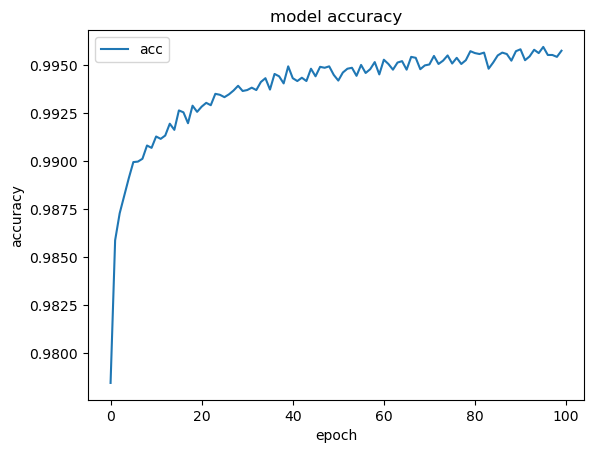

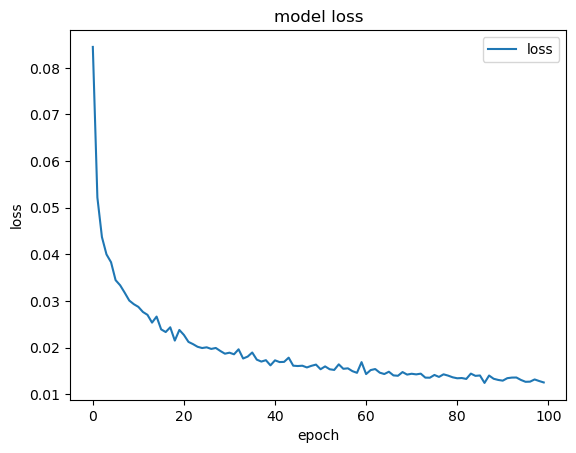

Model Path:model/gru_sae_hybrid/1_8_pkts_gru_f28_sae_f14_archive_withoutIAT/gru_sae_hybrid.h5
316/316 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

      Amazon       0.99      0.96      0.98       427
  CyberGhost       0.99      0.99      0.99       224
      Deezer       0.97      0.94      0.95       340
     Discord       0.91      0.93      0.92       134
     Dropbox       0.99      0.98      0.99       106
        Epic       0.99      0.98      0.99       391
    Facebook       0.97      0.97      0.97        88
     Hotspot       0.92      1.00      0.96       142
      iTunes       0.97      0.95      0.96       149
   Microsoft       0.92      0.87      0.89       141
   ProtonVPN       1.00      1.00      1.00       105
       Skype       0.94      0.92      0.93       185
       Slack       1.00      0.99      0.99       636
  SoulseekQt       1.00      1.00      1.00       151
     Spotify       0.95      0.96      0

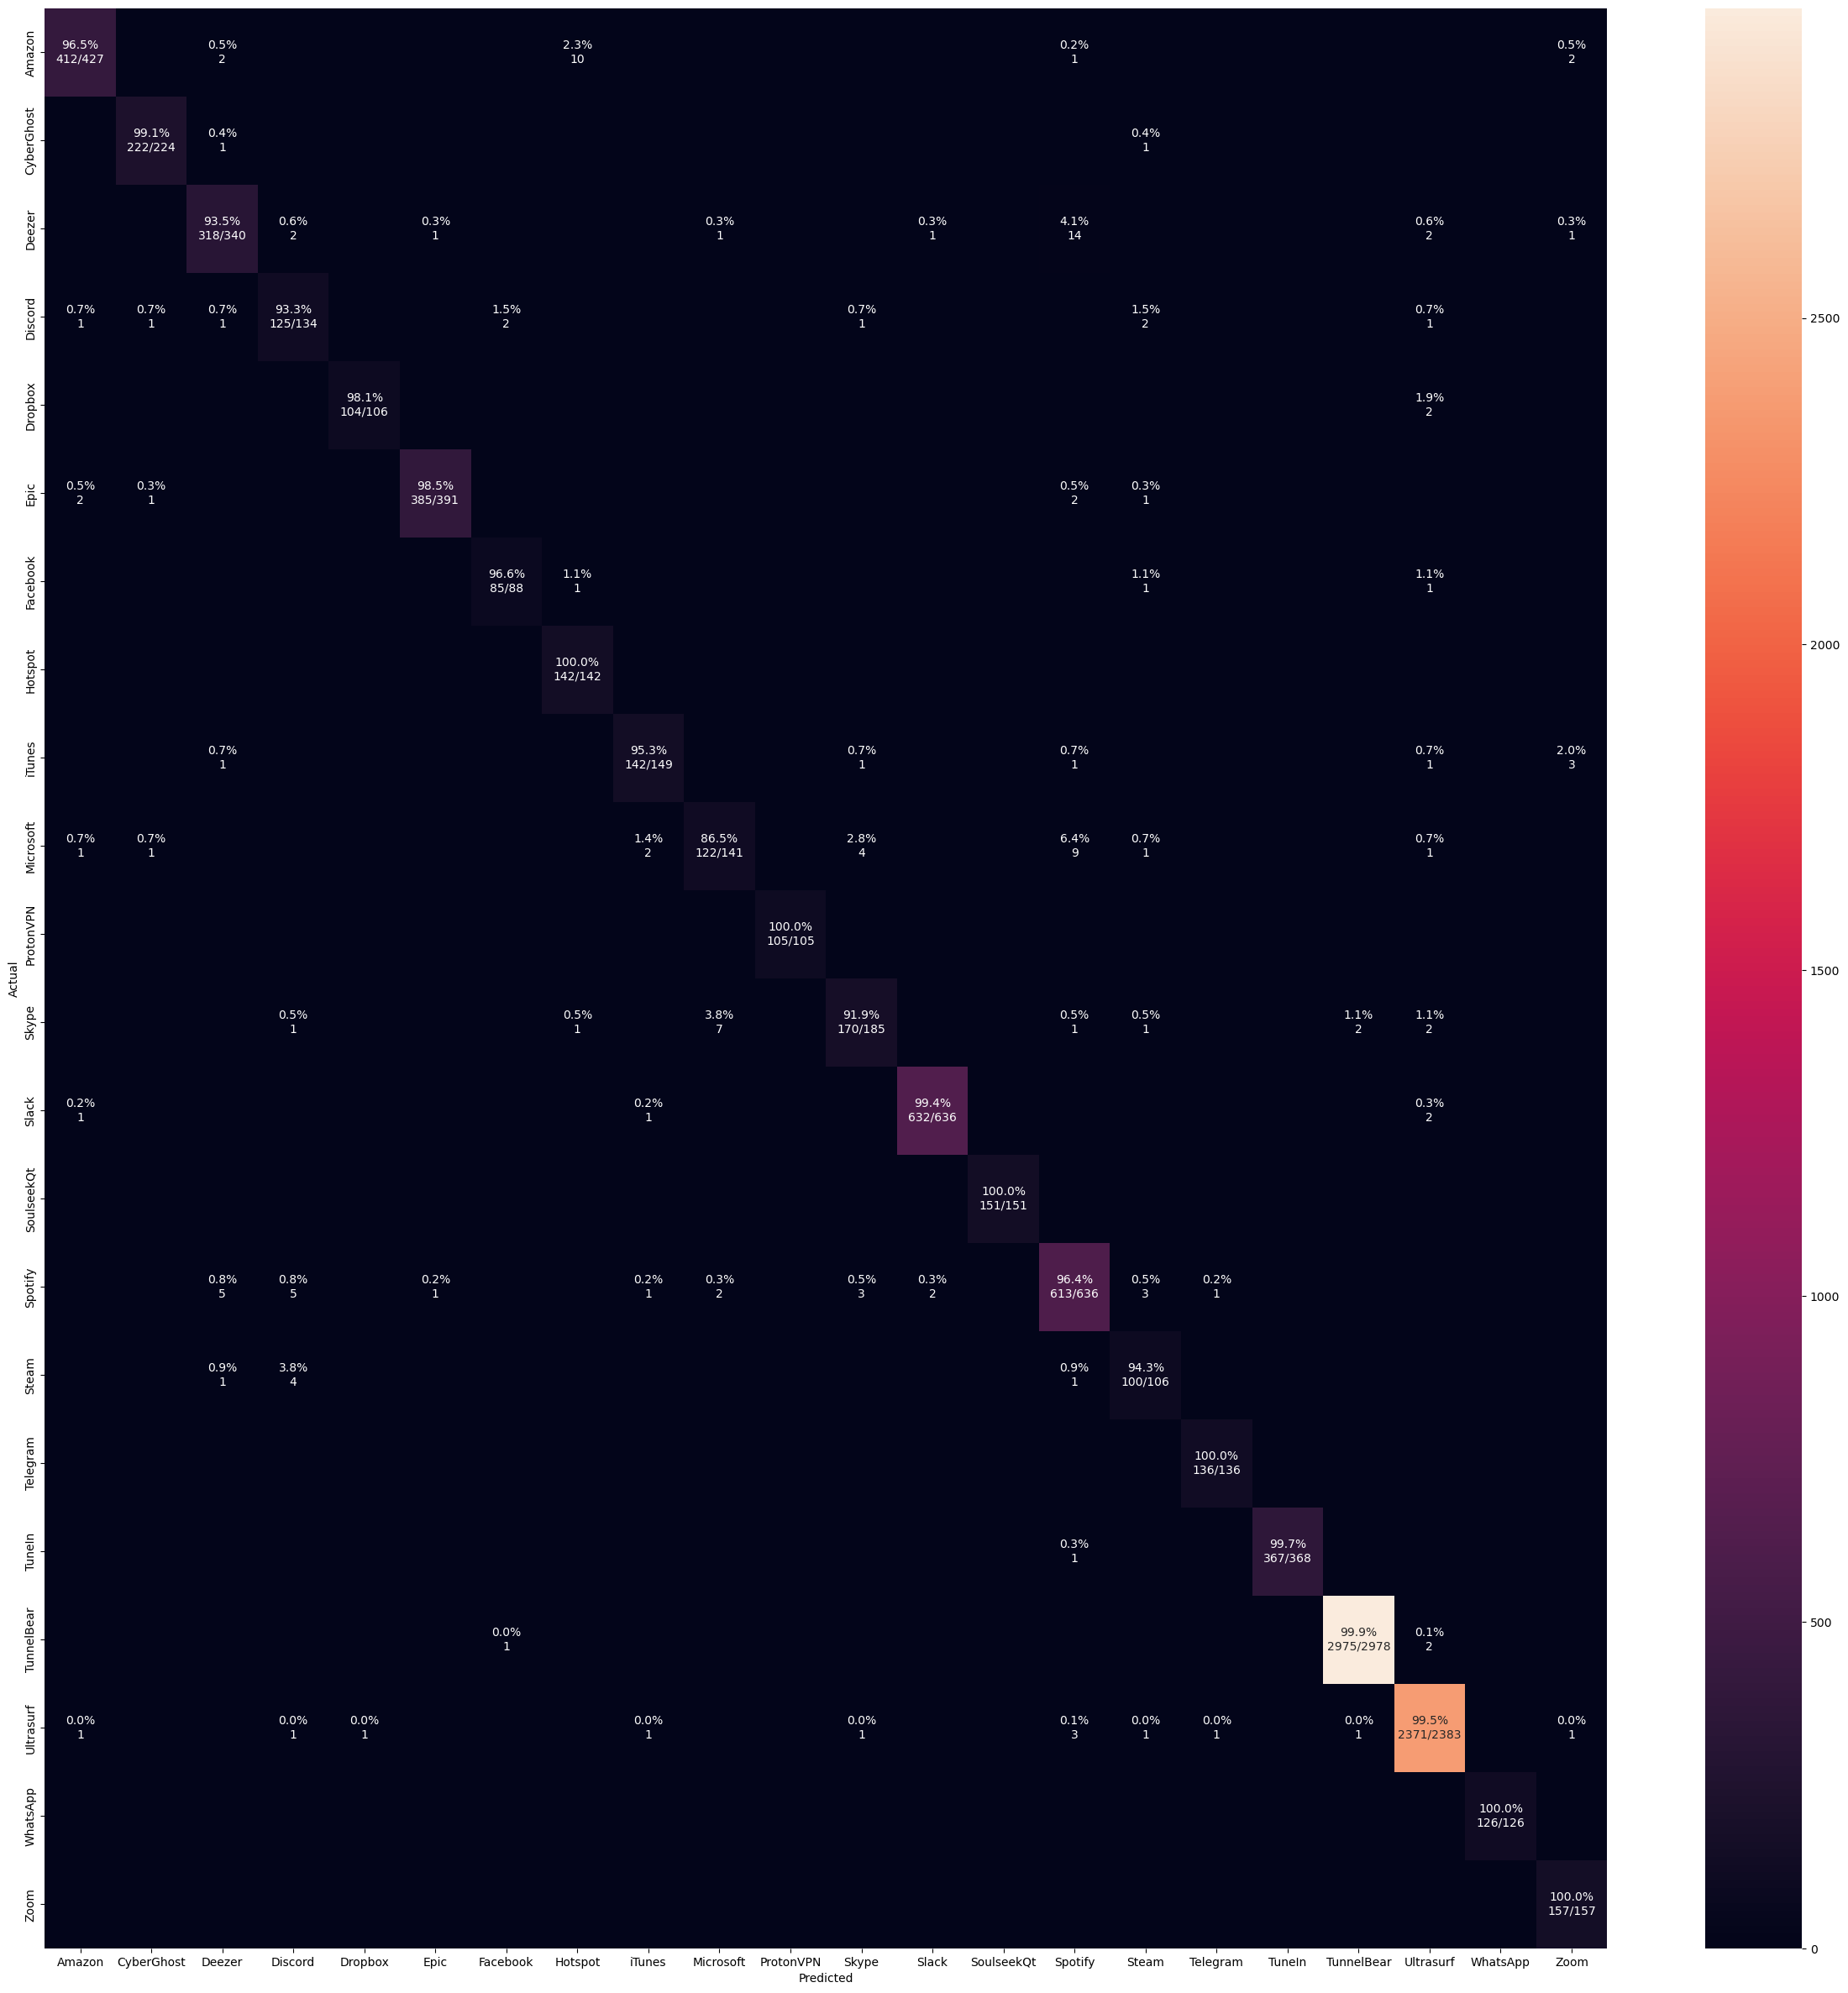

In [10]:
"""
    reference webiste:
        https://github.com/howl-anderson/WeatherBot_NLU/issues/4
        https://blog.csdn.net/jmh1996/article/details/114935105
"""

print(f"{ESTIMATED_ROOT_DIR}/training_log.csv")

# print(get_FLOPs("model/cnn2d_model_2.h5"))
# print(get_FLOPs("autoencoder_1dcnn/4/1dcnn.h5"))
plot_training_history(f"{ESTIMATED_ROOT_DIR}/training_log.csv",  ESTIMATED_ROOT_DIR, hasValidationSet)

model = load_model(f"{ESTIMATED_ROOT_DIR}/{MODEL_NAME}.h5")
print(f"Model Path:{ESTIMATED_ROOT_DIR}/{MODEL_NAME}.h5")

predictions = model.predict(x=[xTestGRU, xTestSAE])
predictions = np.argmax(predictions,axis=1)
cm_analysis(np.argmax(yTestGRU,axis=1), predictions, f"{ESTIMATED_ROOT_DIR}/confusion.png", LABELS, ymap=None, figsize=(30,30))

with open(f'{ESTIMATED_ROOT_DIR}/f1score.txt', 'w') as f:
    ans = classification_report(np.argmax(yTestGRU,axis=1), predictions,  target_names=LABELS)
    f.write(ans)   
    print(ans)

with open(f'{ESTIMATED_ROOT_DIR}/FLOPs.txt', 'w') as f:
    ans = get_FLOPs(f"{ESTIMATED_ROOT_DIR}/{MODEL_NAME}.h5")
    f.write(str(ans))
    print(f"FLOPs:{ans}")